In [ ]:
import pandas as pd
df = pd.read_csv("labeled_patient_eda_hrv_features_60s.csv")
df.head()

,Patient_ID,Condition,Time_Split,SCL_Mean,SCL_STD,SCR_Peaks_Count,EDA_Raw_Mean,EDA_Raw_STD,EDA_Raw_Dynamic_Range,ECG_Mean,...,HRV_MedianRR,HRV_HF,HRV_LF,HRV_LF_HF_Ratio,HRV_SampEN,PANAS_PA,PANAS_NA,Mod_STAI,Stress_label,Anxiety_Level
0,S10,Transition,1,0.728458,0.003345,42000,0.728551,0.013975,0.419617,0.001918,...,624.285714,0.005045,0.044406,8.801894,0.443931,NaN,NaN,NaN,NaN,NaN
1,S10,Transition,2,0.734615,0.002419,42000,0.734707,0.013419,0.299454,0.001407,...,655.714286,0.006522,0.007772,1.191655,1.032654,NaN,NaN,NaN,NaN,NaN
2,S10,Base,3,0.744500,0.002815,42000,0.744245,0.013809,0.286484,0.001372,...,634.285714,0.004447,0.026497,5.958112,0.997516,18.0,12.0,11.0,0.0,1.0
3,S10,Base,4,0.749116,0.001900,42000,0.749359,0.013476,0.398254,0.001438,...,594.285714,0.003043,0.010728,3.525311,1.134330,18.0,12.0,11.0,0.0,1.0
4,S10,Base,5,0.754868,0.002349,42000,0.755048,0.013479,0.315475,0.001172,...,582.857143,0.009533,0.041228,4.324815,0.449403,18.0,12.0,11.0,0.0,1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## Static Feature Analysis

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")
df = df.dropna(subset=['Stress_label'] + feature_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 2 to 1441
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             846 non-null    object 
 1   Condition              846 non-null    object 
 2   Time_Split             846 non-null    int64  
 3   SCL_Mean               846 non-null    float64
 4   SCL_STD                846 non-null    float64
 5   SCR_Peaks_Count        846 non-null    int64  
 6   EDA_Raw_Mean           846 non-null    float64
 7   EDA_Raw_STD            846 non-null    float64
 8   EDA_Raw_Dynamic_Range  846 non-null    float64
 9   ECG_Mean               846 non-null    float64
 10  ECG_Min                846 non-null    float64
 11  ECG_Max                846 non-null    float64
 12  ECG_Median             846 non-null    float64
 13  ECG_STD                846 non-null    float64
 14  HRV_RMSSD              846 non-null    float64
 15  HRV_SDNN  

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")

# Define features (NO time windowing)
feature_cols = [
    'SCL_Mean', 'SCL_STD', 'SCR_Peaks_Count',
    'HRV_RMSSD', 'HRV_SDNN', 'HRV_pNN50',
    'HRV_MeanRR', 'HRV_MedianRR', 'HRV_HF',
    'HRV_LF', 'HRV_LF_HF_Ratio', 'HRV_SampEN'
]

# Drop NaNs and infinite values
df = df.dropna(subset=['Stress_label'] + feature_cols)
df = df.drop(columns="HRV_SDANN")
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize features
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Prepare data arrays
X = df[feature_cols].values
y = df['Stress_label'].values
group_ids = df['Patient_ID'].values

# Define models and parameter grids
models = {
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10]
    }),
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10]
    }),
    'XGBoost': (XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {
        'n_estimators': [50, 100],
        'max_depth': [3, 6]
    }),
    'LightGBM': (LGBMClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [-1, 10]
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0]
    })
}

# Prepare cross-validation
gkf = GroupKFold(n_splits=5)
evaluation_results = []

# Loop through models
for model_name, (model, param_grid) in models.items():
    all_preds, all_true = [], []

    for train_idx, test_idx in gkf.split(X, y, groups=group_ids):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=1)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        all_preds.extend(y_pred)
        all_true.extend(y_test)

    # Metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_true, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_true, all_preds, average='weighted', zero_division=0)

    try:
        auc = roc_auc_score(pd.get_dummies(all_true), pd.get_dummies(all_preds), multi_class='ovr')
    except:
        auc = None

    cm = confusion_matrix(all_true, all_preds)

    evaluation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc,
        'Best Params': grid.best_params_,
        'Confusion Matrix': cm
    })

# Convert to DataFrame
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Confusion Matrix'} for r in evaluation_results])
print(results_df)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:03:57] WARNING: /w

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 11
[LightGBM] [Info] Start training from score -0.653755
[LightGBM] [Info] Start training from score -0.963130
[LightGBM] [Info] Start training from score -2.320604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 11
[LightGBM] [Info] Start training from score -0.655984
[LightGBM] [Info] Start training from score -0.965359
[LightGBM] [Info] Start training from score -2.300360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Start training from score -0.655984
[LightGBM] [Info] Start training from score -0.965359
[LightGBM] [Info] Start training from score -2.300360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 11
[LightGBM] [Info] Start training from score -0.626384
[LightGBM] [Info] Start training from score -0.914066
[LightGBM] [Info] Start training from score -2.739727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 secon

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 673, number of used features: 11
[LightGBM] [Info] Start training from score -0.625641
[LightGBM] [Info] Start training from score -0.913323
[LightGBM] [Info] Start training from score -2.750545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1642
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 11
[LightGBM] [Info] Start training from 

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1642
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 11
[LightGBM] [Info] Start training from score -0.510826
[LightGBM] [Info] Start training from score -1.160488
[LightGBM] [Info] Start training from score -2.445686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 11
[LightGBM] [Info] Start training from score -0.622226
[LightGBM] [Info] Start training from score -1.013273
[LightGBM] [Info] Start training from score -2.300360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 11
[LightGBM] [Info] Start training from score -0.620310
[LightGBM] [Info] Start training from score -1.015497
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 11
[LightGBM] [Info] Start training from score -0.622226
[LightGBM] [Info] Start training from score -1.019427
[LightGBM] [Info] Start training from score -2.278381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 449, number of used features: 11
[LightGBM] [Info] Start training from score -0.660286
[LightGBM] [Info] Start training from score -0.942237
[LightGBM] [Info] Start training from score -2.369353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 11
[LightGBM] [Info] Start training from score -0.662510
[LightGBM] [Info] Start training from score -0.938764
[LightGBM] [Info] Start training from score -2.371578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 11
[LightGBM] [Info] Start training from 

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_sam

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score -0.661028
[LightGBM] [Info] Start training from score -0.941076
[LightGBM] [Info] Start training from score -2.370095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)


                Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0        DecisionTree  0.382423   0.375767  0.382423  0.378850  0.455404   
1  LogisticRegression  0.410926   0.351846  0.410926  0.374344  0.445286   
2        RandomForest  0.402613   0.367245  0.402613  0.382529  0.449538   
3             XGBoost  0.423990   0.403440  0.423990  0.410459  0.469705   
4            LightGBM  0.397862   0.382167  0.397862  0.388882  0.455405   
5            AdaBoost  0.396675   0.373904  0.396675  0.384552  0.451225   

                                   Best Params  
0    {'max_depth': 10, 'min_samples_split': 5}  
1                                    {'C': 10}  
2     {'max_depth': None, 'n_estimators': 100}  
3         {'max_depth': 6, 'n_estimators': 50}  
4       {'max_depth': 10, 'n_estimators': 100}  
5  {'learning_rate': 1.0, 'n_estimators': 100}  


In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Best Params
0,DecisionTree,0.382423,0.375767,0.382423,0.378850,0.455404,"{'max_depth': 10, 'min_samples_split': 5}"
1,LogisticRegression,0.410926,0.351846,0.410926,0.374344,0.445286,{'C': 10}
2,RandomForest,0.402613,0.367245,0.402613,0.382529,0.449538,"{'max_depth': None, 'n_estimators': 100}"
3,XGBoost,0.423990,0.403440,0.423990,0.410459,0.469705,"{'max_depth': 6, 'n_estimators': 50}"
4,LightGBM,0.397862,0.382167,0.397862,0.388882,0.455405,"{'max_depth': 10, 'n_estimators': 100}"
5,AdaBoost,0.396675,0.373904,0.396675,0.384552,0.451225,"{'learning_rate': 1.0, 'n_estimators': 100}"


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [08:13:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 11
[LightGBM] [Info] Start training from score -0.661028
[LightGBM] [Info] Start training from score -0.941076
[LightGBM] [Info] Start training from score -2.370095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

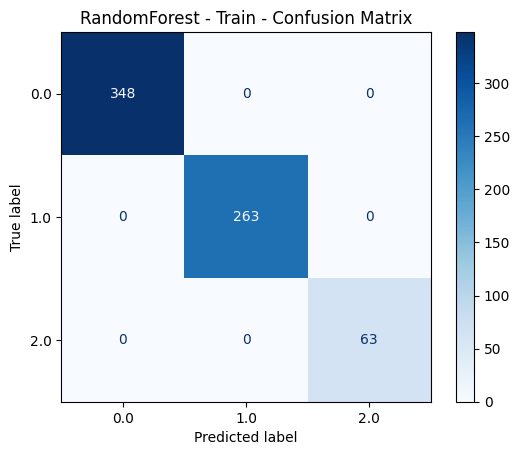

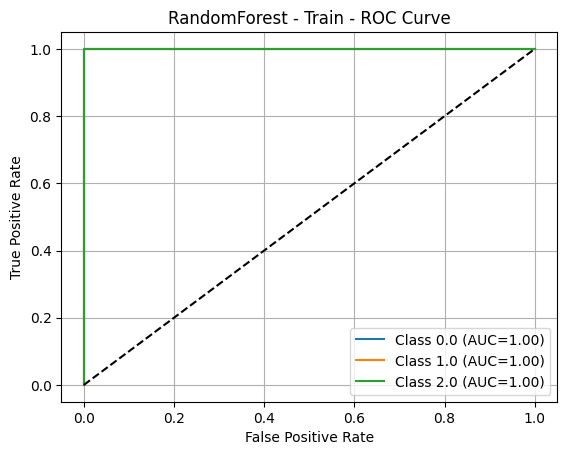

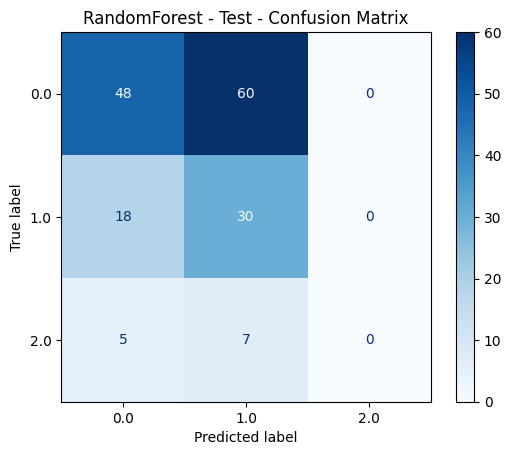

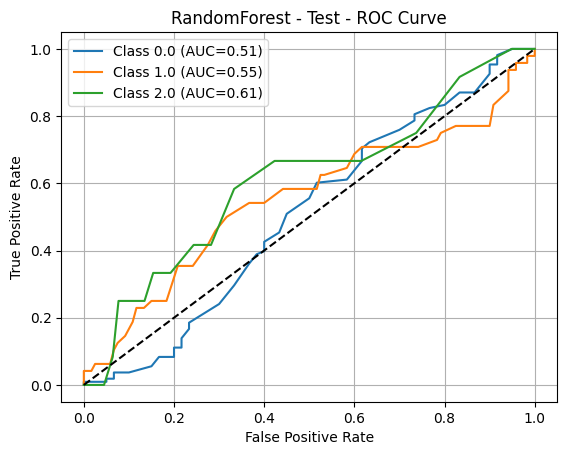

Evaluating DecisionTree...


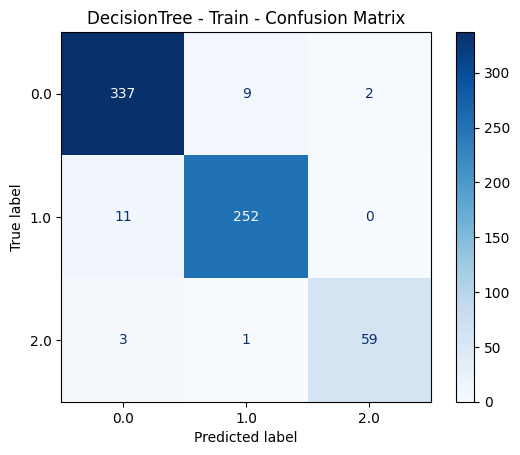

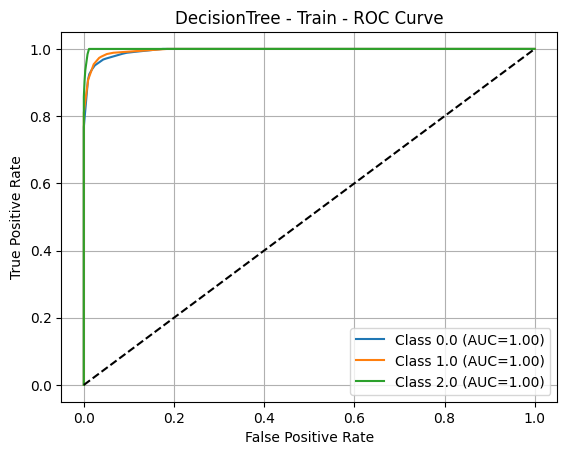

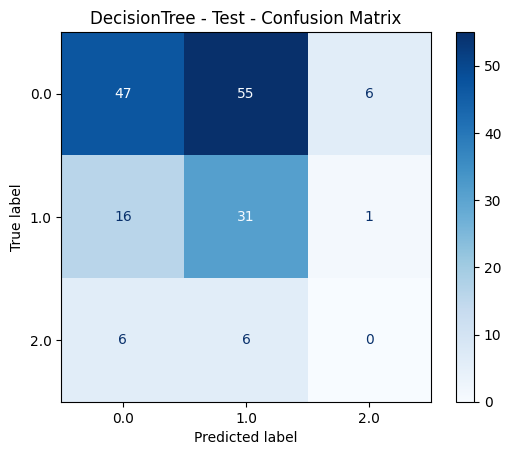

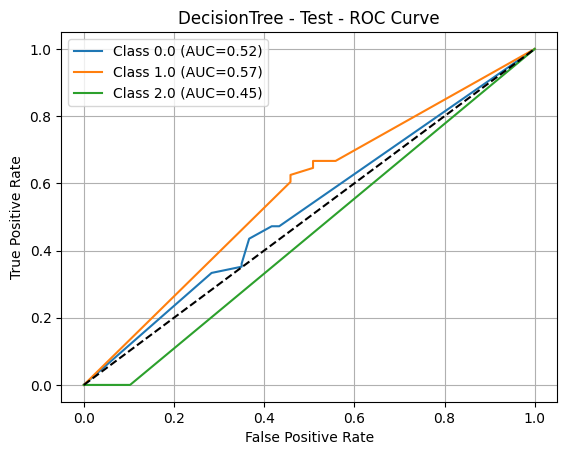

Evaluating LogisticRegression...


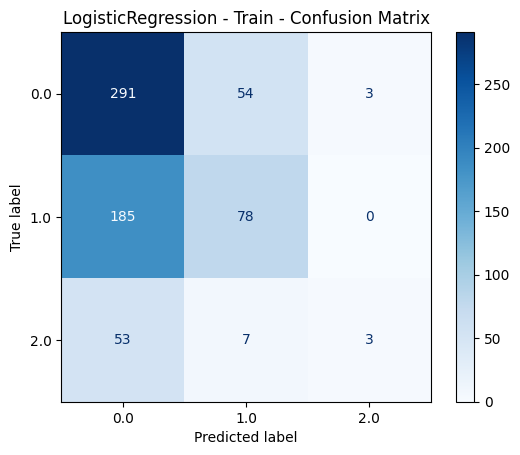

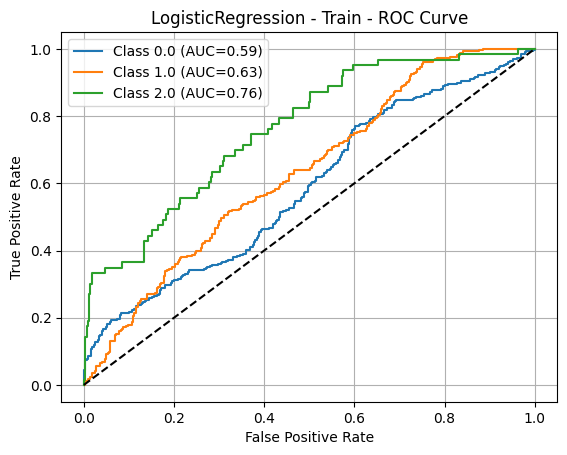

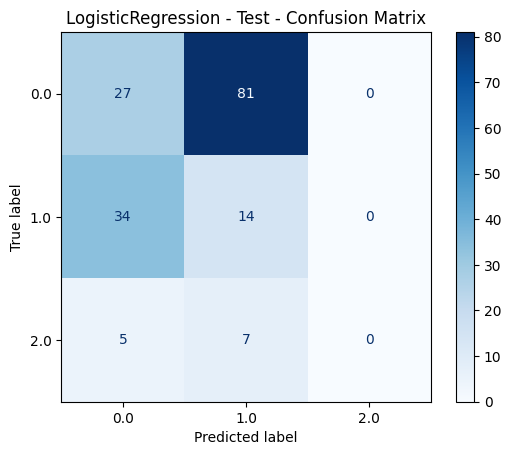

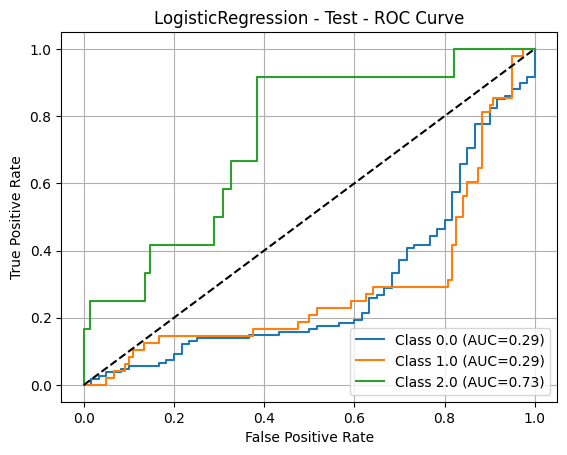

Evaluating XGBoost...


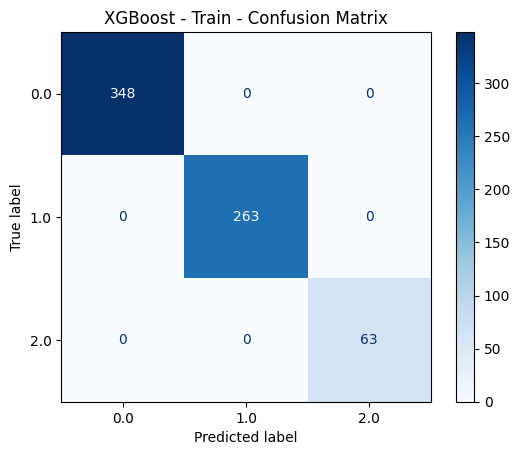

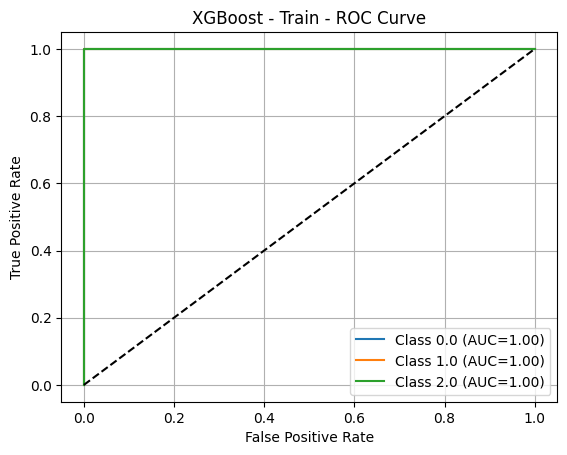

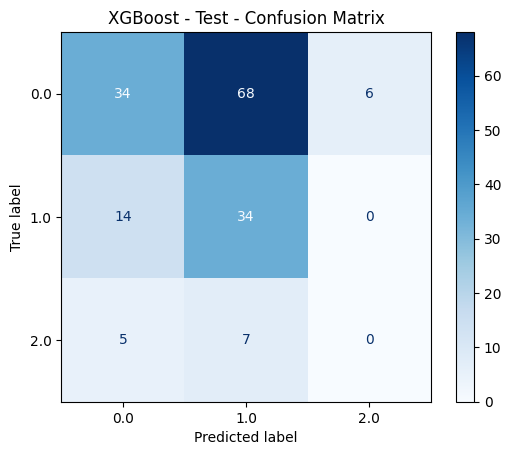

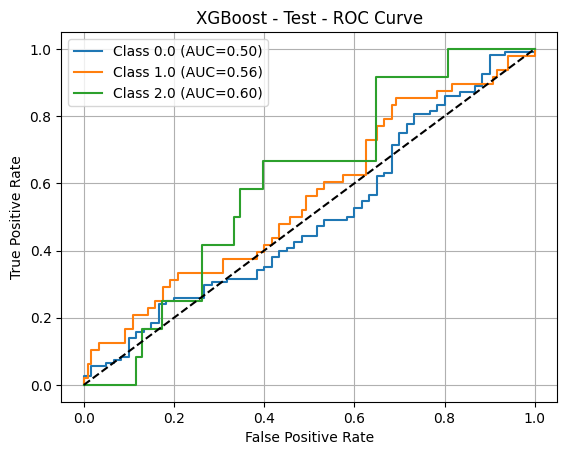

Evaluating AdaBoost...


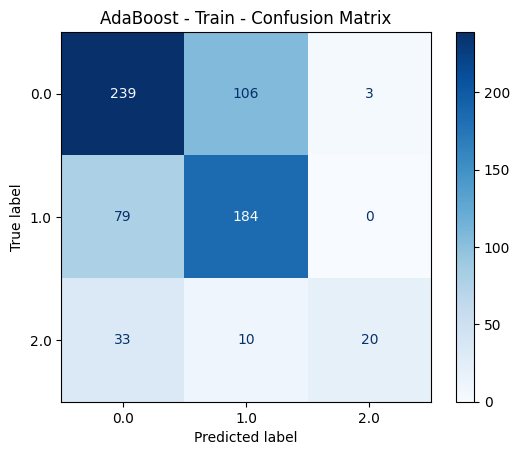

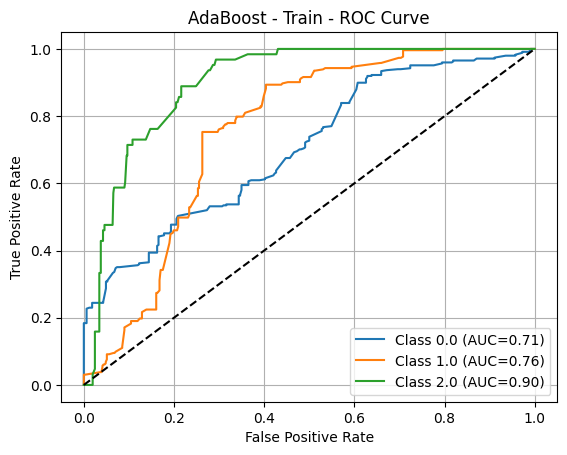

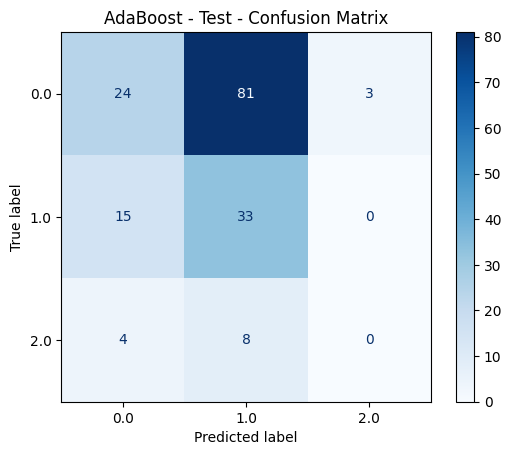

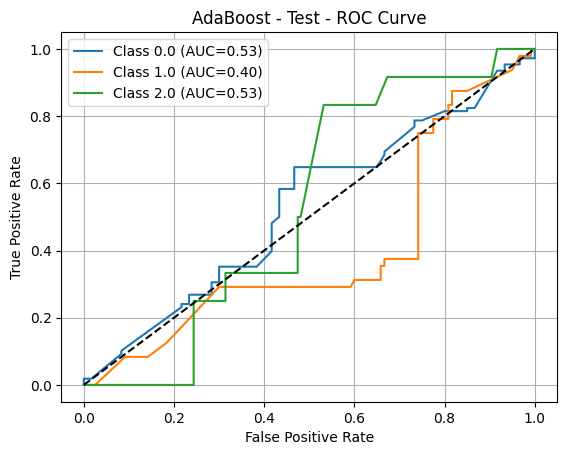

Evaluating LightGBM...


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)


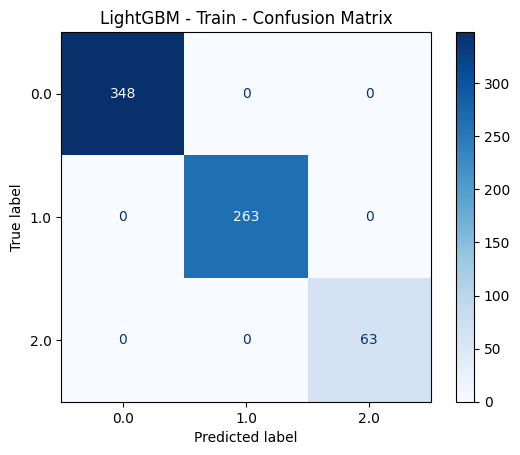

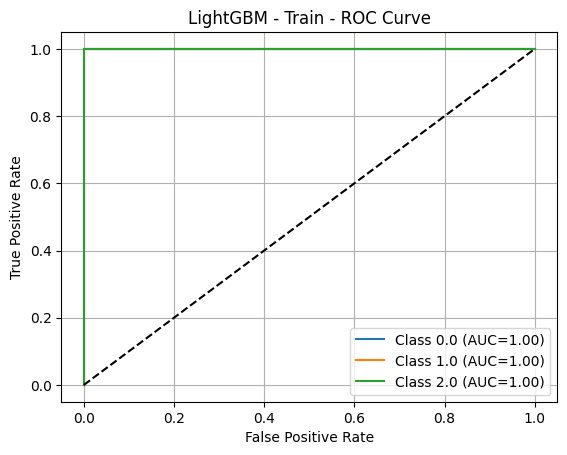

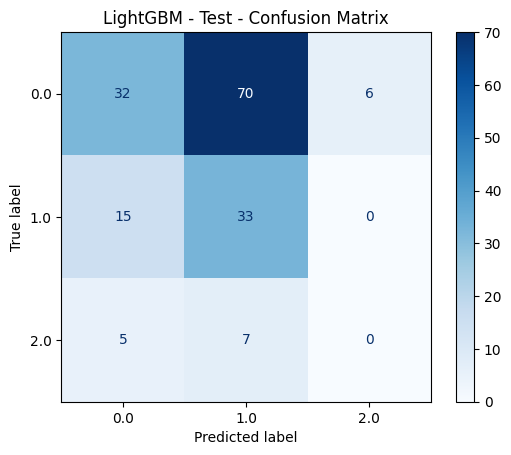

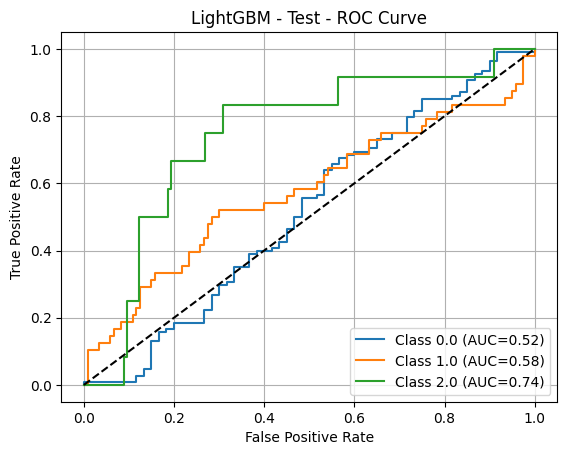

                Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
0        RandomForest        1.000000       0.464286  1.000000  0.462999   
1        DecisionTree        0.961424       0.464286  0.961402  0.467935   
2  LogisticRegression        0.551929       0.244048  0.502196  0.252841   
3             XGBoost        1.000000       0.404762  1.000000  0.395266   
4            AdaBoost        0.657270       0.339286  0.651609  0.315276   
5            LightGBM        1.000000       0.386905  1.000000  0.376492   

   Test AUC  
0  0.557247  
1  0.514905  
2  0.437540  
3  0.553099  
4  0.487299  
5  0.611508  


In [ ]:
from evaluation.py import full_evaluation

# Define your best models (replace with actual fitted GridSearchCV.best_estimator_)
best_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=None).fit(X_train, y_train),
    'DecisionTree': DecisionTreeClassifier(min_samples_split=5, max_depth=10).fit(X_train, y_train),
    'LogisticRegression': LogisticRegression(C=10).fit(X_train, y_train),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=6, use_label_encoder=False).fit(X_train, y_train),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=1.0).fit(X_train, y_train),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=-10).fit(X_train, y_train)
}

# List of classes
classes = sorted(list(set(y)))

# Store evaluation results
evaluation_summaries = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    results = full_evaluation(model, X_train, y_train, X_test, y_test, classes, model_name)

    evaluation_summaries.append({
        'Model': model_name,
        'Train Accuracy': results['Train']['Accuracy'],
        'Test Accuracy': results['Test']['Accuracy'],
        'Train F1': results['Train']['F1 Score'],
        'Test F1': results['Test']['F1 Score'],
        'Test AUC': results['Test']['AUC-ROC']
    })

# Convert to DataFrame for comparison
eval_df = pd.DataFrame(evaluation_summaries)
print(eval_df)


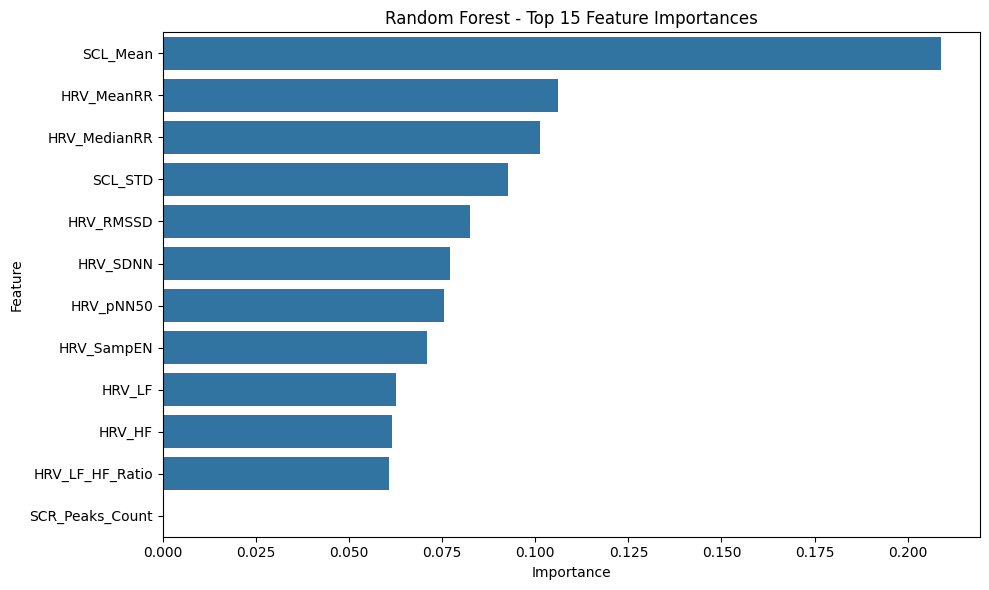

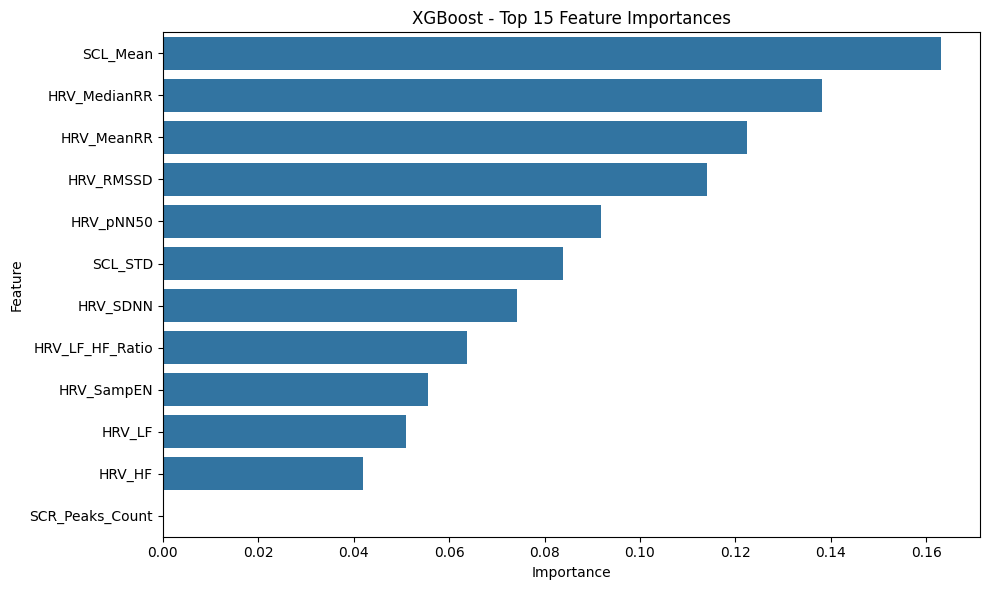

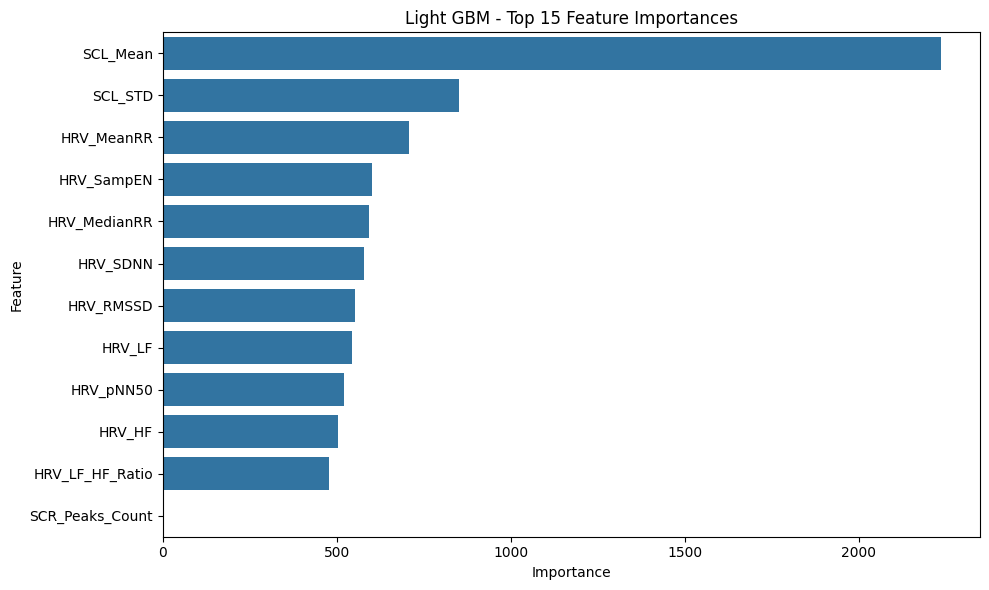

In [ ]:
from feature_importance import plot_feature_importance

best_rf_model = best_models['RandomForest']
best_xgb_model = best_models['XGBoost']
best_lgbm_model = best_models['LightGBM']
# Example usage with your trained models
plot_feature_importance(best_rf_model, feature_cols, model_name="Random Forest")
plot_feature_importance(best_xgb_model, feature_cols, model_name="XGBoost")
plot_feature_importance(best_lgbm_model, feature_cols, model_name="Light GBM")
